# 07 - DS Cadrage métier, Qualité des données et Design de validation

Objectif: montrer la démarche **avant** la modélisation.

Ce notebook documente:
- le problème métier (tarification, fréquence × sévérité),
- la compréhension des colonnes,
- la qualité des données (NA, incohérences, outliers),
- la dérive train/test (drift/OOD),
- la justification des splits de validation anti-fuite.


## Cadrage métier (avant de coder)

**Constat**
- La prime doit être compétitive et rentable.
- Une grosse erreur de tarification est très coûteuse.

**Interprétation**
- Une décomposition actuarielle `fréquence × sévérité` est naturelle et explicable.
- La métrique RMSE est cohérente car elle pénalise fortement les grosses erreurs.

**Décision**
- On documente la démarche two-part et on relie chaque choix de preprocessing/CV à ce cadre.


**Convention de commentaire dans ce notebook (à respecter dans l'analyse)**

- `Constat` : ce que montrent les chiffres/graphes
- `Interprétation` : ce que cela signifie (avec prudence)
- `Décision` : impact pratique sur preprocessing / CV / modèle
- Terminer chaque bloc par une phrase `Impact modèle attendu`


In [2]:
import sys
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.v2_pipeline import (
    DEFAULT_V2_DIR,
    INDEX_COL,
    TARGET_SEV_COL,
    ensure_dir,
    load_train_test,
    prepare_feature_sets,
    build_split_registry,
    validate_folds_disjoint,
    validate_group_disjoint,
    export_split_artifacts_v2,
    compute_ood_diagnostics,
    compute_segment_bias_from_oof,
)

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import v2_pipeline as v2
from src.ds_analysis_utils import *

DATA_DIR = ROOT / "data"
ARTIFACT_DS = ensure_dir(ROOT / DEFAULT_DS_DIR)
ARTIFACT_V2 = ROOT / v2.DEFAULT_V2_DIR

SEED = 42
QUICK_ANALYSIS = True
FULL_ANALYSIS = False
SAMPLE_N = 3000
np.random.seed(SEED)


In [3]:
train_raw, test_raw = load_project_datasets(DATA_DIR)
print("train:", train_raw.shape, "test:", test_raw.shape)
display(train_raw.head(2))
display(test_raw.head(2))


train: (50000, 33) test: (50000, 28)


,index,id_client,id_vehicule,id_contrat,bonus,type_contrat,duree_contrat,anciennete_info,freq_paiement,paiement,...,marque_vehicule,modele_vehicule,debut_vente_vehicule,fin_vente_vehicule,vitesse_vehicule,type_vehicule,prix_vehicule,poids_vehicule,nombre_sinistres,montant_sinistre
0,0,A00000001,V01,A00000001-V01,0.5,Maxi,29,9,Biannual,No,...,PEUGEOT,306,10,9,182,Tourism,20700,1210,0,0.0
1,1,A00000002,V01,A00000002-V01,0.5,Maxi,3,1,Biannual,No,...,MERCEDES BENZ,C220,4,2,229,Tourism,34250,1510,0,0.0


,index,bonus,type_contrat,duree_contrat,anciennete_info,freq_paiement,paiement,utilisation,code_postal,conducteur2,...,din_vehicule,essence_vehicule,marque_vehicule,modele_vehicule,debut_vente_vehicule,fin_vente_vehicule,vitesse_vehicule,type_vehicule,prix_vehicule,poids_vehicule
0,50000,0.58,Maxi,1,1,Yearly,No,Retired,28388,No,...,55,Gasoline,RENAULT,CLIO,16,15,150,Tourism,10321,830
1,50001,0.50,Median2,2,2,Yearly,No,Retired,19123,No,...,96,Diesel,MERCEDES BENZ,C220,16,12,175,Tourism,24652,1400


In [4]:
# Data contract + dictionnaire de données
data_dict = build_data_dictionary(train_raw, test_raw)
col_types = classify_columns(train_raw, test_raw)
leakage_risk = detect_leakage_risk_columns(train_raw)

display(data_dict.head(20))
display(col_types[["column","role_guess","dtype_train","nunique_train","missing_rate_train","high_cardinality_train"]].head(20))
display(leakage_risk)


,column,present_train,present_test,dtype_train,dtype_test,nunique_train,nunique_test,missing_rate_train,missing_rate_test,sample_values_train,role_guess
0,code_postal,1,1,object,object,12790,12806.0,0.00000,0.00000,36233 | 92073 | 92026,categorical
1,conducteur2,1,1,object,object,2,2.0,0.00000,0.00000,No | No | No,categorical
2,essence_vehicule,1,1,object,object,3,3.0,0.00000,0.00000,Gasoline | Diesel | Gasoline,categorical
3,freq_paiement,1,1,object,object,4,4.0,0.00000,0.00000,Biannual | Biannual | Yearly,categorical
4,marque_vehicule,1,1,object,object,89,88.0,0.00000,0.00000,PEUGEOT | MERCEDES BENZ | BMW,categorical
5,modele_vehicule,1,1,object,object,886,894.0,0.00000,0.00000,306 | C220 | Z3,categorical
6,paiement,1,1,object,object,2,2.0,0.00000,0.00000,No | No | No,categorical
7,sex_conducteur1,1,1,object,object,2,2.0,0.00000,0.00000,M | M | M,categorical
8,sex_conducteur2,1,1,object,object,3,3.0,0.66812,0.66816,F | M | F,categorical
9,type_contrat,1,1,object,object,4,4.0,0.00000,0.00000,Maxi | Maxi | Maxi,categorical


,column,role_guess,dtype_train,nunique_train,missing_rate_train,high_cardinality_train
0,code_postal,categorical,object,12790,0.00000,1
1,conducteur2,categorical,object,2,0.00000,0
2,essence_vehicule,categorical,object,3,0.00000,0
3,freq_paiement,categorical,object,4,0.00000,0
4,marque_vehicule,categorical,object,89,0.00000,0
5,modele_vehicule,categorical,object,886,0.00000,1
6,paiement,categorical,object,2,0.00000,0
7,sex_conducteur1,categorical,object,2,0.00000,0
8,sex_conducteur2,categorical,object,3,0.66812,0
9,type_contrat,categorical,object,4,0.00000,0


,column,risk_types,risk_level,recommended_action
0,id_client,identifier,high,exclude_as_feature
1,id_contrat,identifier,high,exclude_as_feature
2,id_vehicule,identifier,high,exclude_as_feature
3,index,identifier,high,exclude_as_feature
4,montant_sinistre,target,high,target_only
5,nombre_sinistres,target,high,target_only
6,code_postal,post_event_suspect,medium,manual_review


**À commenter (cellule précédente)**

- `Constat`: quelles colonnes sont des identifiants (`index`, `id_client`, `id_vehicule`, `id_contrat`) ?
- `Interprétation`: pourquoi ces colonnes créent un risque de fuite ou d'apprentissage non généralisable ?
- `Décision`: colonnes à exclure comme features brutes.
- **Impact modèle attendu**: baisse du risque d'overfitting et meilleure robustesse privée.


,metric,value
0,n_train,50000.000000
1,claim_rate,0.058340
2,n_claims_pos,2917.000000
3,sev_mean_pos,1771.843401
4,sev_median_pos,1236.000000
5,sev_q95_pos,4355.258000
6,sev_q99_pos,6963.118800
7,sev_max_pos,21826.960000


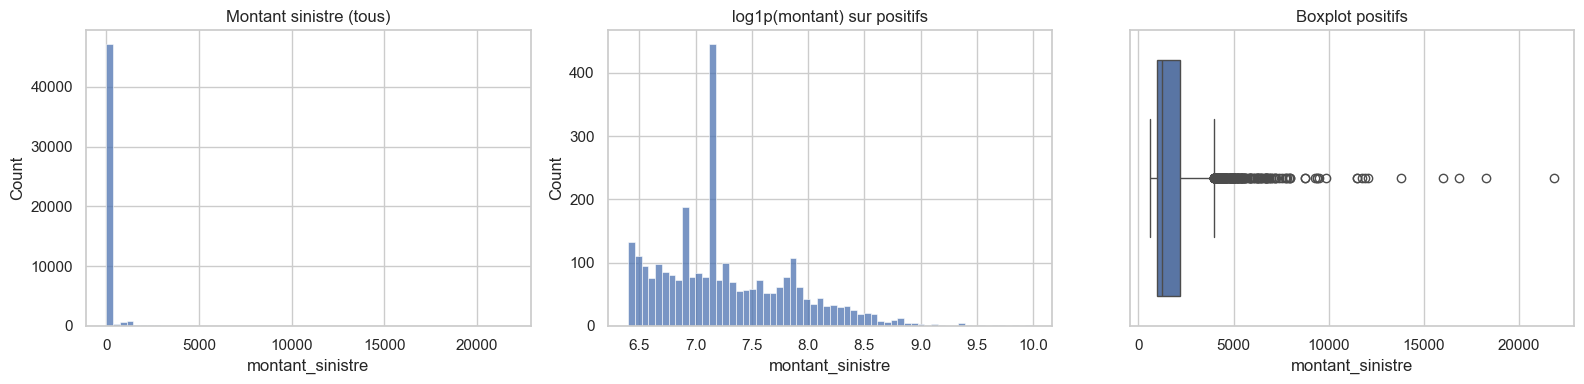

In [5]:
# Cibles fréquence / sévérité
y_sev = train_raw[v2.TARGET_SEV_COL].astype(float)
y_freq = (y_sev > 0).astype(int)
y_pos = y_sev[y_sev > 0]

target_summary = pd.DataFrame([
    {"metric": "n_train", "value": len(train_raw)},
    {"metric": "claim_rate", "value": float(y_freq.mean())},
    {"metric": "n_claims_pos", "value": int(y_freq.sum())},
    {"metric": "sev_mean_pos", "value": float(y_pos.mean()) if len(y_pos) else np.nan},
    {"metric": "sev_median_pos", "value": float(y_pos.median()) if len(y_pos) else np.nan},
    {"metric": "sev_q95_pos", "value": float(y_pos.quantile(0.95)) if len(y_pos) else np.nan},
    {"metric": "sev_q99_pos", "value": float(y_pos.quantile(0.99)) if len(y_pos) else np.nan},
    {"metric": "sev_max_pos", "value": float(y_pos.max()) if len(y_pos) else np.nan},
])
display(target_summary)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(y_sev, bins=60, ax=axes[0])
axes[0].set_title("Montant sinistre (tous)")
sns.histplot(np.log1p(y_pos), bins=60, ax=axes[1])
axes[1].set_title("log1p(montant) sur positifs")
sns.boxplot(x=y_pos, ax=axes[2], orient="h")
axes[2].set_title("Boxplot positifs")
plt.tight_layout()


**À commenter**
- `Constat`: rareté des sinistres + forte asymétrie / queue lourde de la sévérité.
- `Interprétation`: pourquoi `log1p` et/ou Tweedie sont des candidats naturels.
- `Décision`: conserver l'approche two-part et soigner la couverture de queue.


,scope,group_col,group_value,column,missing_rate_train,missing_rate_test,missing_gap_test_minus_train
292,global,None,None,sex_conducteur2,0.66812,0.66816,0.00004
269,global,None,None,anciennete_vehicule,0.00002,0.00000,-0.00002
264,global,None,None,age_conducteur1,0.00000,0.00000,0.00000
267,global,None,None,anciennete_permis1,0.00000,0.00000,0.00000
265,global,None,None,age_conducteur2,0.00000,0.00000,0.00000
268,global,None,None,anciennete_permis2,0.00000,0.00000,0.00000
270,global,None,None,bonus,0.00000,0.00000,0.00000
271,global,None,None,code_postal,0.00000,0.00000,0.00000
266,global,None,None,anciennete_info,0.00000,0.00000,0.00000
273,global,None,None,cylindre_vehicule,0.00000,0.00000,0.00000


,scope,group_col,group_value,column,missing_rate_train,missing_rate_test,missing_gap_test_minus_train
224,by_group,conducteur2,No,sex_conducteur2,1.000000,NaN,NaN
226,by_group,type_vehicule,Commercial,sex_conducteur2,0.787268,NaN,NaN
229,by_group,utilisation,Professional,sex_conducteur2,0.727025,NaN,NaN
230,by_group,utilisation,Retired,sex_conducteur2,0.724146,NaN,NaN
228,by_group,utilisation,AllTrips,sex_conducteur2,0.708333,NaN,NaN
227,by_group,type_vehicule,Tourism,sex_conducteur2,0.654987,NaN,NaN
231,by_group,utilisation,WorkPrivate,sex_conducteur2,0.638809,NaN,NaN
47,by_group,utilisation,WorkPrivate,anciennete_vehicule,0.000030,NaN,NaN
40,by_group,conducteur2,No,anciennete_vehicule,0.000030,NaN,NaN
43,by_group,type_vehicule,Tourism,anciennete_vehicule,0.000022,NaN,NaN


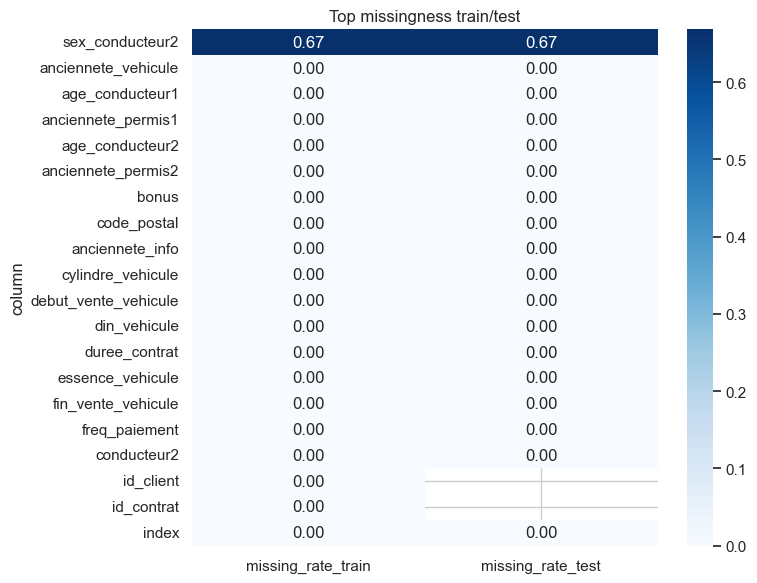

In [6]:
# Missingness global + par sous-population
missing_report = compute_missingness_report(
    train_raw, test_raw, group_cols=["utilisation", "type_vehicule", "conducteur2"]
)
missing_global = missing_report[missing_report["scope"] == "global"].copy()
display(missing_global.sort_values("missing_rate_train", ascending=False).head(20))

pivot_missing = (
    missing_global[["column","missing_rate_train","missing_rate_test"]]
    .set_index("column")
    .sort_values("missing_rate_train", ascending=False)
    .head(20)
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_missing, annot=True, fmt=".2f", cmap="Blues")
plt.title("Top missingness train/test")
plt.tight_layout()

missing_group = missing_report[missing_report["scope"] == "by_group"].copy()
display(missing_group.sort_values("missing_rate_train", ascending=False).head(20))


In [7]:
# Règles métier / incohérences / petits sinistres / zéros techniques
rule_violations = compute_rule_violations(train_raw)
display(rule_violations)

zero_tech = pd.DataFrame([
    {
        "column": c,
        "zero_rate_train": float((pd.to_numeric(train_raw[c], errors='coerce') == 0).mean()),
        "zero_rate_test": float((pd.to_numeric(test_raw[c], errors='coerce') == 0).mean()) if c in test_raw.columns else np.nan,
    }
    for c in ["poids_vehicule", "cylindre_vehicule"]
    if c in train_raw.columns
])
display(zero_tech)


,check_name,rule,n_violations,ratio_violations,example_indices
0,poids_zero_or_neg,poids_vehicule <= 0,1883,0.03766,"28,36,42,45,48"
1,permis_gt_age_conducteur2,anciennete_permis2 > age_conducteur2,397,0.00794,"99,133,154,221,550"
2,permis_gt_age_conducteur1,anciennete_permis1 > age_conducteur1,12,0.00024,"1044,1345,1346,12595,21824"
3,cylindre_zero_or_neg,cylindre_vehicule <= 0,3,0.00006,"41748,41750,46971"
4,age_conducteur1_impossible,"age_conducteur1 out of [16,100]",1,0.00002,6851
5,sinistre_negatif,montant_sinistre < 0,0,0.00000,
6,petit_sinistre_lt_50,0 < montant_sinistre < 50,0,0.00000,


,column,zero_rate_train,zero_rate_test
0,poids_vehicule,0.03766,0.03722
1,cylindre_vehicule,0.00006,0.00004


## Discussion attendue: sinistres négatifs, petits sinistres, extrêmes

**Constat**
- Le dataset peut contenir des valeurs atypiques (négatives, très petites, extrêmes).

**Interprétation**
- En assurance, ces cas peuvent refléter des conventions de gestion, des remboursements, ou du bruit.

**Décision (à défendre en soutenance)**
- Tagger systématiquement ces cas.
- Comparer plusieurs stratégies (laisser / winsoriser pour l'apprentissage / traiter la queue séparément).
- Ne jamais masquer une décision de nettoyage sans trace analytique.


In [8]:
# Doublons exacts et quasi-doublons (hors cible)
n_dup_exact = int(train_raw.duplicated().sum())
feature_cols_wo_target = [c for c in train_raw.columns if c not in [v2.TARGET_FREQ_COL, v2.TARGET_SEV_COL]]
n_dup_wo_target = int(train_raw.duplicated(subset=feature_cols_wo_target).sum())
dup_report = pd.DataFrame([
    {"check": "duplicate_rows_exact", "count": n_dup_exact},
    {"check": "duplicate_rows_wo_target", "count": n_dup_wo_target},
])
display(dup_report)


,check,count
0,duplicate_rows_exact,0
1,duplicate_rows_wo_target,0


In [9]:
# Drift train/test numérique + catégoriel + cardinalité
num_cols = [c for c in train_raw.columns if str(train_raw[c].dtype).startswith(("int","float")) and c in test_raw.columns]
cat_cols = [c for c in train_raw.columns if train_raw[c].dtype == "object" and c in test_raw.columns]

drift_num = compute_drift_numeric_ks_psi(train_raw, test_raw, num_cols=num_cols, bins=10)
drift_cat = compute_drift_categorical_chi2(train_raw, test_raw, cat_cols=cat_cols, top_k=50)
cardinality = build_cardinality_report(train_raw, test_raw)
ood = v2.compute_ood_diagnostics(train_raw.astype(object), test_raw.astype(object))

display(drift_num.head(20))
display(drift_cat.head(20))
display(cardinality.head(20))
display(ood.sort_values("unseen_test_levels", ascending=False).head(20))


,column,n_train_non_null,n_test_non_null,mean_train,mean_test,median_train,median_test,std_train,std_test,ks_stat,ks_pvalue,psi
0,index,50000,50000,24999.500000,74999.500000,24999.5,74999.5,14433.756727,14433.756727,1.000000,0.000000,12.433856
1,din_vehicule,50000,50000,91.547520,91.237380,87.0,87.0,34.489591,34.131069,0.004980,0.563030,0.000662
2,anciennete_vehicule,49999,50000,9.531091,9.572820,8.0,8.0,7.012082,7.041990,0.003815,0.858702,0.000603
3,vitesse_vehicule,50000,50000,170.731340,170.634680,170.0,170.0,23.441265,23.293836,0.004020,0.812341,0.000483
4,poids_vehicule,50000,50000,1129.088460,1127.326580,1130.0,1125.0,361.002771,360.272977,0.005560,0.420691,0.000365
5,prix_vehicule,50000,50000,18095.562080,18021.820880,16250.0,16200.0,8715.016777,8610.964544,0.004520,0.684922,0.000349
6,debut_vente_vehicule,50000,50000,11.628320,11.679120,10.0,10.0,7.756015,7.823188,0.004180,0.773250,0.000319
7,fin_vente_vehicule,50000,50000,8.653180,8.693160,7.0,7.0,6.619835,6.667459,0.004180,0.773250,0.000298
8,anciennete_permis1,50000,50000,32.444980,32.534720,32.0,33.0,13.470294,13.460016,0.003860,0.848880,0.000247
9,bonus,50000,50000,0.537911,0.536762,0.5,0.5,0.098998,0.097089,0.005340,0.472364,0.000228


,column,train_unique,test_unique,unseen_test_levels,unseen_ratio_on_test_levels,unseen_ratio_on_test_rows,chi2_stat_topk,chi2_pvalue_topk,chi2_dof_topk,top_train_levels
0,code_postal,12790,12806,5004,0.390754,0.14964,68.311791,0.125161,56.0,31555 | 67482 | 06088 | 59350 | 75115 | 44109 ...
1,modele_vehicule,886,894,137,0.153244,0.00412,37.104331,0.911902,50.0,CLIO | 206 | TWINGO | SCENIC | MEGANE | 307 | ...
2,marque_vehicule,89,88,12,0.136364,0.00038,42.642447,0.819319,52.0,RENAULT | PEUGEOT | CITROEN | VOLKSWAGEN | FOR...
3,type_contrat,4,4,0,0.000000,0.00000,3.112860,0.374550,3.0,Maxi | Median2 | Median1 | Mini
4,freq_paiement,4,4,0,0.000000,0.00000,3.761547,0.288391,3.0,Yearly | Monthly | Biannual | Quarterly
5,paiement,2,2,0,0.000000,0.00000,0.006282,0.936826,1.0,No | Yes
6,utilisation,4,4,0,0.000000,0.00000,2.508432,0.473769,3.0,WorkPrivate | Retired | Professional | AllTrips
7,conducteur2,2,2,0,0.000000,0.00000,0.000045,0.994642,1.0,No | Yes
8,sex_conducteur1,2,2,0,0.000000,0.00000,0.001503,0.969080,1.0,M | F
9,sex_conducteur2,3,3,0,0.000000,0.00000,1.571064,0.455877,2.0,nan | F | M


,column,dtype_train,nunique_train,nunique_test,top1_ratio_train,rare_ratio_train_lt10
0,index,int64,50000,50000.0,0.00002,1.000000
1,id_contrat,object,50000,NaN,0.00002,1.000000
2,id_client,object,45785,NaN,0.00010,1.000000
3,code_postal,object,12790,12806.0,0.00490,0.928225
4,prix_vehicule,int64,4752,4691.0,0.01014,0.780934
5,montant_sinistre,float64,2260,NaN,0.94166,0.996018
6,poids_vehicule,int64,968,959.0,0.03766,0.501033
7,modele_vehicule,object,886,894.0,0.07214,0.586907
8,cylindre_vehicule,int64,532,521.0,0.06476,0.535714
9,din_vehicule,int64,207,205.0,0.09224,0.352657


,diagnostic_type,feature,train_unique,test_unique,unseen_test_levels,unseen_ratio_on_levels
0,ood,index,50000,50000,50000,1.000000
8,ood,code_postal,12790,12806,5004,0.390754
26,ood,prix_vehicule,4752,4691,1173,0.250053
21,ood,modele_vehicule,886,894,137,0.153244
27,ood,poids_vehicule,968,959,98,0.102190
17,ood,cylindre_vehicule,532,521,82,0.157390
18,ood,din_vehicule,207,205,22,0.107317
20,ood,marque_vehicule,89,88,12,0.136364
24,ood,vitesse_vehicule,176,174,9,0.051724
1,ood,bonus,73,69,7,0.101449


**À commenter (drift/OOD)**

- `Constat`: OOD fort sur granularité fine (ex. `code_postal`, `modele_vehicule`) vs plus faible sur agrégats (`cp2/cp3`).
- `Interprétation`: certaines colonnes demandent hiérarchies/fallbacks plutôt qu'un traitement brut.
- `Décision`: prioriser robustesse OOD (rare grouping, TE cross-fit, hiérarchies géographiques).


In [10]:
# Justification du split / validation anti-fuite
splits = v2.build_split_registry(train_raw, n_blocks_time=5, n_splits_group=5, group_col="id_client")
split_rows = []
for split_name, folds in splits.items():
    v2.validate_folds_disjoint(
        folds,
        check_full_coverage=(split_name in {"secondary_group", "aux_blocked5"}),
        n_rows=len(train_raw),
    )
    if split_name == "secondary_group":
        v2.validate_group_disjoint(folds, train_raw["id_client"])
    for fold_id, (tr_idx, va_idx) in folds.items():
        split_rows.append(
            {
                "split": split_name,
                "fold_id": int(fold_id),
                "n_train": int(len(tr_idx)),
                "n_valid": int(len(va_idx)),
            }
        )
split_summary = pd.DataFrame(split_rows)
display(split_summary)


,split,fold_id,n_train,n_valid
0,primary_time,1,10000,10000
1,primary_time,2,20000,10000
2,primary_time,3,30000,10000
3,primary_time,4,40000,10000
4,secondary_group,1,40000,10000
5,secondary_group,2,40000,10000
6,secondary_group,3,40000,10000
7,secondary_group,4,40000,10000
8,secondary_group,5,40000,10000
9,aux_blocked5,1,40000,10000


## OOF / GroupKFold / anti-fuite (rappel pédagogique)

- **GroupKFold**: toutes les lignes d'un même `id_client` restent dans le même fold.
- **OOF**: chaque ligne est prédite par un modèle qui ne l'a jamais vue.
- **Pourquoi c'est crucial ici**: sinon, on mesure un score optimiste et on augmente le risque de shake-up public/privé.


In [11]:
# Exports d'analyse (Notebook 1)
tables = {
    "data_dictionary": data_dict,
    "column_typing_report": col_types,
    "leakage_risk_report": leakage_risk,
    "missingness_report": missing_report,
    "rule_violations_report": rule_violations,
    "drift_numeric_ks_psi": drift_num,
    "drift_categorical_chi2": drift_cat,
    "cardinality_report": cardinality,
}
export_analysis_tables(tables, ARTIFACT_DS)
print("Exports DS notebook 1 ->", ARTIFACT_DS)


Exports DS notebook 1 -> c:\Users\icemo\Downloads\Calcul-prime-d-assurance\artifacts\ds


## Synthèse Notebook 1 (à compléter)

**Risques identifiés**
- [ ] fuite via identifiants
- [ ] OOD catégoriel sur granularité fine
- [ ] extrêmes de sévérité / queue lourde
- [ ] incohérences et zéros techniques

**Mitigations retenues**
- [ ] split multi-schémas (`primary_time`, `secondary_group`, `aux_blocked5`)
- [ ] hiérarchies/fallbacks OOD
- [ ] traitements robustes de sévérité (log/Tweedie/tail mapping)
- [ ] traçabilité des règles de nettoyage
